# Predicting Houston Restaurant Popularity with Income Trends
The purpose of this project is to correlate income bracket data with foursquare restaurant data over time to predict restaurant trends within Houston zip codes.

## Data sources
1. irs.gov tax statistics:  https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi
1. Census geographic data: https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/tx_texas_zip_codes_geo.min.json
1. Foursquare venue data (similar to labs)

## Methodology
1. Download, import, and clean up IRS data for Houston over the previous 5-year period
1. Examine the data for anomolies and quality issues
1. Perform a regression analysis to predict Houston zip code income data in 2020
1. Pull foursquare venue data for each of the Houston zip codes
1. Drop any data outside of the restaurant industry
1. Correlate restaurant type with income data
1. Extend correlation to predict restaurant trends in zip codes
1. Identify specific zip codes with that differ or are expected to differ strongly from the predictions and use this data to recommend new restaurant placement



In [1]:
##Import relevant libraries
#basic libraries
import numpy as np
import pandas as pd

#geographic libraries
import json # handle JSON files
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # Handle Foursquare API requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#!conda install -c conda-forge folium --yes
import folium # map rendering library
from folium import plugins
#!conda install -c conda-forge geopandas --yes
#import geopandas as gpd #geojson to pandas # Issues importing with fiona import error

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans



In [2]:
#Reload most recent progress
irs_file = 'IRS DATA.csv' # file with income data
zips_file = 'HOUSTON ZIPS.csv' # file with geographic data
houston_file = 'HOUSTON.csv' # file with combined data
foursquare_file = 'foursquare_data.csv' # file with venue data
venue_count_file = 'venue_count.csv' # file with venue totals
HI_venue_count_file = 'HI_venue_count.csv' # file with high income venues
restaurant_type_totals_file = 'type_totals.csv' # file with venue type totals
clustered_file = 'houston_clustered.csv' # file with zip code clusters
high_income_file = "houston_high_income.csv" # file with only high-income zip codes
houston_JSON_file = "HOUSTON ZIPS.json"

#Reload IRS Data and change necessary datatypes back to strings
irs_data = pd.read_csv(irs_file)
irs_data = irs_data.astype({'zip code' : str, 'year' : str}).reset_index(drop = True)
houston_zips_combined = irs_data['zip code'].unique()
print('IRS Data Loaded')

#Reload zip code data and change necessary datatypes back to strings
houston_zips_df = pd.read_csv(zips_file)
houston_zips_df = houston_zips_df.astype({'zip code' : str}).reset_index(drop = True)
zip_latlong_lookup = dict(zip(houston_zips_df['zip code'], zip(houston_zips_df['latitude'], houston_zips_df['longitude'])))
print('Zip Code Data Loaded')

#Reload combined data and change necessary datatypes back to strings
houston_df = pd.read_csv(houston_file)
houston_df = houston_df.astype({
    'zip code' : str, 
    'year' : str,
    'latitude' : float,
    'longitude' : float
    }).reset_index(drop = True)
print('Combined Data Loaded')

#Reload foursqure data
venues_df = pd.DataFrame()
try:
    venues_df = pd.read_csv(foursquare_file)
    venues_df = venues_df.astype(
        {'zip code' : str,
         'restaurant latitude' : float, 
         'restaurant longitude' : float})
    print('Foursquare Data Loaded')
except:
    print(foursquare_file + ' not found')
    
#Reload venue analyzed data
houston_venue_count_df = pd.read_csv(venue_count_file)
houston_venue_count_df = houston_venue_count_df.astype({'zip code' : str})
restaurant_type_total_df = pd.read_csv(restaurant_type_totals_file)
houston_HI_venue_count_df = pd.read_csv(HI_venue_count_file)
houston_HI_venue_count_df = houston_HI_venue_count_df.astype({'zip code' : str})
houston_HI_venue_scaled_df = pd.read_csv("HI_venue_count_scaled.csv")
houston_HI_venue_scaled_df = houston_HI_venue_scaled_df.astype({'zip code' : str})
print('Venue Data Loaded')

#Reload clustered data
houston_clustered_df = pd.read_csv(clustered_file)
houston_clustered_df = houston_clustered_df.astype({
    'zip code' : str, 
    'year' : str,
    'latitude' : float,
    'longitude' : float
    }).reset_index(drop = True)
houston_HI_df = pd.read_csv(high_income_file)
houston_HI_df = houston_HI_df.astype({
    'zip code' : str, 
    'year' : str,
    'latitude' : float,
    'longitude' : float
    }).reset_index(drop = True)
houston_HI_zips = houston_HI_df['zip code'].unique()
houston_cluster_lookup = dict(zip(houston_HI_df['zip code'], houston_HI_df['cluster']))
print('Clustered Data Loaded')

#define variables to be used in later analysis so they don't require definition in more than one place
radius = 1609 * 2 #2 miles

IRS Data Loaded
Zip Code Data Loaded
Combined Data Loaded
Foursquare Data Loaded
Venue Data Loaded
Clustered Data Loaded


In [49]:
houston_HI_venue_count_df

zip code  cluster  Afghan Restaurant  African Restaurant  \
0     77002        2                  0                   2   
1     77005        2                  0                   0   
2     77006        5                  0                   2   
3     77007        5                  0                   0   
4     77008        5                  0                   1   
5     77019        2                  0                   0   
6     77024        2                  0                   4   
7     77025        5                  0                   0   
8     77027        5                  0                   4   
9     77030        5                  0                   0   
10    77056        2                  0                   5   
11    77079        5                  0                   0   
12    77094        4                  0                   0   
13    77098        5                  0                   0   
14    77401        4                  0                   3   
15    77450        5                  1                   0   
16    77478        5                  0                   1   
17    77479        4                  0                   0   

    American Restaurant  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0                   134       0                 0                       1   
1                   128       0                 1                       0   
2                   160       0                 1                       1   
3                   106       0                 2                       0   
4                    78       0                 0                       0   
5                   130       0                 3                       0   
6                    37       0                 0                       6   
7                    40       0                 0                       0   
8                   148       0                 0                       7   
9                   104       0                 0                       0   
10                  147       1                 0                       7   
11                   31       0                 0                       0   
12                   18       0                 0                       0   
13                  137       0                 1                       0   
14                   52       0                 0                       0   
15                   22       0                 0                       2   
16                   66       3                 1                       1   
17                   14       0                 0                       0   

    Asian Restaurant  BBQ Joint  ...  Theme Restaurant  Tiki Bar  \
0                 25         47  ...                 6         0   
1                 41         20  ...                 0         0   
2                 34         36  ...                 2         0   
3                 12          5  ...                 0         0   
4                 14         24  ...                 0         1   
5                 29         17  ...                 1         0   
6                 23         13  ...                 0         0   
7                 13         35  ...                 0         0   
8                 37         12  ...                 0         0   
9                 12         42  ...                 0         0   
10                25         12  ...                 0         0   
11                26          3  ...                 0         0   
12                 9          0  ...                 0         0   
13                51         24  ...                 0         0   
14                17          5  ...                 0         0   
15                12          3  ...                 0         0   
16                23         16  ...                 0         0   
17                 6          4  ...                 1         0   

    Turkish Restaurant  Vegetarian / Vegan Resta

## Import and process the data
1. Identify Houston zip codes (limited to inside the beltway)
1. Create empty dataframe for yearly dataframes and lists of years to be pulled
1. Set the URL format from irs.gov
1. Define columns to keep and their simplified names (columns from https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi) NOTE:  $ amounts are in thousands
1. For each year:
 1. pull datafile for each year
 2. filter to only Houston zip codes (starting with 77)
 2. remove unneeded columns
 2. get totals for each column
 2. merge totals back into one datafile
 2. calculate normalized income scores
 2. calculate high earner columns
 2. set year column and add to irs_data DataFrame
1. Calculate average household income in a new column

In [8]:
#setup houston zip codes. limiting to area inside the beltway, the energy corridor, and Sugar Land
added = list([77401, 77948, 77502, 77503, 77504, 77506, # inside the beltway
              77547, 77587, 77063, 77071, 77074, 77075, 
              77076, 77078, 77080, 77081, 77086, 77087, 
              77088, 77091, 77092, 77093, 77096, 77098,
              77077, 77079, 77082, 77084, 77449, 77450, # energy corridor 
              77094,
              77083, 77072, 77099, 77498, 77478, 77479, # Sugar Land
              77406, 77407, 77477])
removed = list([77014, 77032, 77053, 77058, 77059, 77062]) 
houston_zips = list(range(77000, 77065, 1)) + added
for element in removed:
    houston_zips.remove(element)
    
# pull all data into a single dataframe
irs_data = pd.DataFrame()
url = "https://www.irs.gov/pub/irs-soi/{0}zpallagi.csv"
years = ['12', '13', '14', '15', '16']

# Define friendly names for columns
columns = {'zipcode' : 'zip code',
           'AGI_STUB' : 'income bracket',
           'N1' : 'returns',
           'NUMDEP' : 'dependents',
           'A00100' : 'total AGI',
           #'N02650' : 'number income', # not in all years
           #'A02650' : 'total income',
           'N02300' : 'number unemployment',
           'A02300' : 'total unemployement',
           'N02500' : 'number social security',
           'A02500' : 'total social security',
           #'N03230' : 'number tuition deduction', # not in all years
           #'A03230' : 'total tuition deduction',
           #'N18800' : 'number property taxes', # not in all years
           #'A18800' : 'total property taxes',
           'N19300' : 'number mortgage interest',
           'A19300' : 'total mortgage interest',
           'N19700' : 'number charitable contributions',
           'A19700' : 'total charitable contributions',
           'N04800' : 'number taxable income',
           'A04800' : 'total taxable income',
           'N07180' : 'number child care credit',
           'A07180' : 'total child care credit',
           'N07220' : 'number child tax credit',
           'A07220' : 'total child tax credit',
           #'N10600' : 'number tax payments', # not in all years
           #'A10600' : 'total tax payments', # not in all years
           'N06500' : 'number income tax',
           'A06500' : 'total income tax',
           'N11901' : 'number taxes due',
           'A11901' : 'total taxes due',
           'N11902' : 'number refunds due',
           'A11902' : 'total refunds due'
          }

# Keep only the columns of interest
keep_columns = ['zip code',
                'income bracket',
                'returns',
                'dependents',
                'total AGI']

# variables to help combine zip codes that skew the results
zips_to_combine = {'77010' : '77002',
                   '77046' : '77027'}
columns_to_move = ['income bracket', 
                   'returns', 
                   'total AGI']
columns_to_sum = ['returns', 
                  'total AGI']

# define helper function to apply weights to each income bracket
# assumes income brackets are in ascending order
# Create a normalized income score for each zip code for each year
# each incremental income bracket is worth 0.2 points
# i.e a zip code with all earners in the top bracket would have a normalized score of 1.0
# a zip code with all earners in the bottom bracket would have a normalized score of 0.0
# a zip code with a perfectly even distribution of earners would have a normalized score of (0.0 + 0.2 + 0.4 + 0.6 + 0.8 + 1.0) / 6 = 0.5
weights = [0.0, # totals row
           0.0, # lowest bracket (1)
           0.2, # second bracket (2)
           0.4, # third bracket (3)
           0.6, # fourth bracket (4)
           0.8, # fifth bracket (5)
           1.0] # top bracket (6)
def normalize(df):    
    df['normalized income score'] = sum(df['returns'] * weights) / df[df['income bracket'] == 0]['returns'].iloc[0]
    return df  

#define helper function to sum high earners
# sum number of returns in top 2 brackets and add to a column
# divide high earners by total earners and add to a column
def high_earners(df):
    highearners = df[df['income bracket'] == 5]['returns'].iloc[0] + df[df['income bracket'] == 6]['returns'].iloc[0]
    df['total high earners'] = highearners
    df['percent high earners'] = highearners / df[df['income bracket'] == 0]['returns'].iloc[0]
    return df

#urls['2012'] = "https://www.irs.gov/pub/irs-soi/12zpallagi.csv"
#urls['2013'] = "https://www.irs.gov/pub/irs-soi/13zpallagi.csv"
#urls['2014'] = "https://www.irs.gov/pub/irs-soi/14zpallagi.csv"
#urls['2015'] = "https://www.irs.gov/pub/irs-soi/15zpallagi.csv"
#urls['2016'] = "https://www.irs.gov/pub/irs-soi/16zpallagi.csv"

for year in years:
    # read dataframe from URL
    year_df = pd.read_csv(url.format(year))
    #print(year, 'has shape', year_df.shape)
    
    # filter to Houston zip codes
    #year_df = year_df[year_df['zipcode'] % 77000 < 1000].reset_index(drop = True)
    #year_df = year_df[year_df['zipcode'] != 0].reset_index(drop = True)
    year_df = year_df[year_df['zipcode'].isin(houston_zips)].reset_index(drop = True)
    #print(year, 'has shape', year_df.shape, 'after dropping zip codes')
    
    # remove and rename columns
    year_df.rename(columns = {'agi_stub' : 'AGI_STUB'}, inplace = True) # inconsistent naming by year
    year_df = year_df[columns.keys()].rename(columns = columns)
    year_df = year_df[keep_columns]
    year_df = year_df.astype({'zip code' : str}).reset_index(drop = True)
    #print(year, 'has shape', year_df.shape, 'after dropping columns')
    
    # Merge zip codes that skew resulting plots   
    for key in zips_to_combine:
        combined = year_df[year_df['zip code'].isin([key, zips_to_combine[key]])]\
            .groupby('income bracket')[columns_to_sum].sum().reset_index()
        year_df.loc[(year_df['zip code'] == zips_to_combine[key]), columns_to_move] = combined[columns_to_move].to_numpy()
        year_df = year_df[year_df['zip code'] != key].reset_index(drop = True)
    year_df = year_df.astype({'income bracket' : int})
    
    # add totals row
    year_totals_df = year_df.groupby('zip code').sum().reset_index()
    year_totals_df['income bracket'] = 0
    year_df = pd.concat([year_df, year_totals_df], sort = False)
    #print(year, 'has shape', year_df.shape, 'after adding totals')

    # add column for normalized income score
    # sort by zip code and then income bracket, then weight returns for each bracket, then add column back in and reset index
    year_df = year_df.sort_values(by = ['zip code', 'income bracket']).groupby('zip code').apply(normalize).reset_index(drop = True)

    # add columns for high earners
    # sort by zip code and then income bracket, then sum returns in top 2 brackets, then divide by total returns, then add columns back in and reset index
    year_df = year_df.sort_values(by = ['zip code', 'income bracket']).groupby('zip code').apply(high_earners).reset_index(drop = True)
    
    #add column for year and add to consoldiated dataframe
    year_df['year'] = '20' + year
    irs_data = pd.concat([irs_data, year_df], sort = False)
    
    print(year, 'successfully processed')
    
# Add average household income (based on AGI)
irs_data['average household income'] = irs_data['total AGI'] / irs_data['returns']

# reset index after all the concatenations
irs_data.reset_index(drop = True, inplace = True)

# ignore merged zip codes
houston_zips_combined = irs_data['zip code'].unique()

# write to CSV file to allow later sessions to skip this cell
irs_data.to_csv("IRS DATA.csv", index=False)

12 successfully processed
13 successfully processed
14 successfully processed
15 successfully processed
16 successfully processed


In [7]:
irs_data.head()

zip code  income bracket  returns  total AGI  normalized income score  \
0    77002               0   4880.0  2067824.0                 0.433197   
1    77002               1   1400.0    16191.0                 0.433197   
2    77002               2    840.0    31306.0                 0.433197   
3    77002               3    650.0    39887.0                 0.433197   
4    77002               4    420.0    36213.0                 0.433197   

   total high earners  percent high earners  year  average household income  
0              1570.0              0.321721  2012                423.734426  
1              1570.0              0.321721  2012                 11.565000  
2              1570.0              0.321721  2012                 37.269048  
3              1570.0              0.321721  2012                 61.364615  
4              1570.0              0.321721  2012                 86.221429

## Gather Zip Code Geographic Data
1. Pull GEOJSON File with zip code boundaries (https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/tx_texas_zip_codes_geo.min.json) saved locally (data cleaned from census data from https://www.census.gov/cgi-bin/geo/shapefiles2010/main)
1. Copy features with Houston zip codes into another file, renaming used features for readability
1. Pull new file into a GeoPandas Dataframe
1. Merge IRS dataframe with GeoPandas Dataframe to consolidate financial and geographic data


In [3]:
# read GEOJSON file
with open('tx_zip_codes.json') as json_data:
    tx_data = json.load(json_data)
    
# remove ZIP codes not in geo data
tmp = tx_data
geozips = []
columns = {'ZCTA5CE10' : 'zip code',
           'ALAND10' : 'land area',
           'AWATER10' : 'water area',
           'INTPTLAT10' : 'latitude',
           'INTPTLON10' : 'longitude'
          }

for i in range(len(tmp['features'])):    
    # check for Houston zip code
    if (tmp['features'][i]['properties']['ZCTA5CE10'] in houston_zips_combined):        
        # Rename columns
        for key in columns:
            tmp['features'][i]['properties'][columns[key]] = tmp['features'][i]['properties'].pop(key)        
        # add to new feature list
        geozips.append(tmp['features'][i])
print('Found', len(geozips), 'zip codes')

# put data in new JSON dictionary
houston_data = dict.fromkeys(['type', 'features'])
houston_data['type'] = 'FeatureCollection'
houston_data['features'] = geozips

# write JSON dictionary to file and read back into a GeoPandas DataFrame
# Geopandas has issues with install on cognitiveclassAI
#with open('houston_zip_codes.json', 'w') as f:
#   json.dump(houston_data, f)
# houston_zips_df = gpd.read_file('houston_zip_codes.json')
# houston_zips_df = houston_zips_df[list(columns.values())]

# Read into Datafile with JSON_Normalize
columns = {'properties.land area' : 'land area',
           'properties.water area' : 'water area',
           'properties.latitude' : 'latitude', 
           'properties.longitude' : 'longitude',
           'properties.zip code' : 'zip code'}
houston_zips_df = json_normalize(geozips).rename(columns = columns)[list(columns.values())]

# write to CSV and JSON files to allow later sessions to skip this cell
houston_zips_df.to_csv("HOUSTON ZIPS.csv", index=False)
with open('HOUSTON ZIPS.json', 'w') as f:
   json.dump(houston_data, f)

Found 92 zip codes


In [9]:
houston_zips_df.head()

land area  water area   latitude  longitude zip code
0   16112274       11938  29.670870 -95.585990    77099
1   17881915      318808  29.773179 -95.314327    77020
2   22650287      213335  29.791808 -95.228991    77013
3    6567398       67910  29.749808 -95.345901    77003
4   16006249       20223  29.795344 -95.367590    77009

## Combine Income and Geographic Data
1. Merge IRS data with GeoJSON data
1. Add columns for population and income density
1. Add a column for high earner density

In [4]:
# merge with IRS data
houston_df = irs_data.merge(houston_zips_df, left_on = 'zip code', right_on = 'zip code')

# Add area and density columns
houston_df['total area'] = (houston_df['land area'] + houston_df['water area'])  # area in meters squared
# houston_df['households per hectare'] = 10000 * houston_df['returns'] / houston_df['total area']  # factor in hectare conversion
houston_df['households per section'] = 2589988.1 * houston_df['returns'] / houston_df['total area']  # factor in square mile (section) conversion
houston_df['income per section'] = 2589988.1 * houston_df['total AGI'] / houston_df['total area']  # factor in square mile (section) conversion
#houston_df['high earners per section'] = 2589988.1 * houston_df['total high earners'] / houston_df['total area']

# Create a normalized wealth score for each zip code for each year
# each incremental income bracket is worth 0.2 points
# i.e a zip code with all earners in the top bracket would have a normalized score of 1.0
# a zip code with all earners in the bottom bracket would have a normalized score of 0.0
# a zip code with a perfectly even distribution of earners would have a normalized score of (0.2 + 0.4 + 0.6 + 0.8 + 1.0) / 6 = 0.5 
houston_df['normalized income score'] = 0
for zip in houston_zips_combined:
    for year in years:
        norm = 0
        for bracket in range(2, 7):
            returns_in_bracket = houston_df[(houston_df['zip code'] == zip) 
                                            & (houston_df['year'] == '20' + year) 
                                            & (houston_df['income bracket'] == bracket)]['returns'].iloc[0]
            norm = norm + 0.2 * (bracket - 1) * returns_in_bracket
            
        total_returns = houston_df[(houston_df['zip code'] == zip) 
                                            & (houston_df['year'] == '20' + year) 
                                            & (houston_df['income bracket'] == 0)]['returns'].iloc[0]
        
        # set normalized wealth
        houston_df.loc[(houston_df['zip code'] == zip)
                & (houston_df['year'] == '20' + year), 'normalized income score'] = norm / total_returns
        
        high_earners = houston_df[(houston_df['zip code'] == zip) 
                                            & (houston_df['year'] == '20' + year) 
                                            & (houston_df['income bracket'] == 5)]['returns'].iloc[0] + \
                       houston_df[(houston_df['zip code'] == zip) 
                                            & (houston_df['year'] == '20' + year) 
                                            & (houston_df['income bracket'] == 6)]['returns'].iloc[0]
        
        # set number of high earners        
        houston_df.loc[(houston_df['zip code'] == zip)
                & (houston_df['year'] == '20' + year), 'total high earners'] = high_earners
        
        # set percentage of high earners
        houston_df.loc[(houston_df['zip code'] == zip)
                & (houston_df['year'] == '20' + year), 'percent high earners'] = high_earners / total_returns
        
        # set high earner density      
        total_area = houston_df[(houston_df['zip code'] == zip) 
                                            & (houston_df['year'] == '20' + year) 
                                            & (houston_df['income bracket'] == 0)]['total area'].iloc[0]     
        houston_df.loc[(houston_df['zip code'] == zip)
                & (houston_df['year'] == '20' + year), 'high earners per section'] = 2589988.1 * high_earners / total_area
        
# write to CSV file to allow later sessions to skip this cell
houston_df.to_csv("HOUSTON.csv", index=False)         

## Pull Foursquare Data
For each ZIP code
1. Pull all restaurant venues within a radius
2. Count restaurants by zip code
3. Merge restaurant count into main DataFrame
4. Make DataFrame with restaurant count per type in new columns

TX zip code boundaries from https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/tx_texas_zip_codes_geo.min.json

zip code sql file from http://nominatim.org/data/country_grid.sql.gz

zillow data https://www.zillow.com/howto/api/neighborhood-boundaries.htm


In [5]:
# Foursquare login info
CLIENT_ID = 'IFOFLQZABA4PUGGM45MTUJ5F0OR23SO2DX0YSKK2VKEVPIMR' # your Foursquare ID
CLIENT_SECRET = 'CXA2DM0L2KVYMRGFNQI0TDX1GALXDVCS5BMV20OFZRUOALFC' # your Foursquare Secret
VERSION = '20190615'

# Restaurant Category IDs From Foursquare, to avoid 100 venue limits
category_IDs = \
      ['4bf58dd8d48988d149941735', '4bf58dd8d48988d1ca941735',
       '4bf58dd8d48988d146941735', '4bf58dd8d48988d1cc941735',
       '4bf58dd8d48988d16c941735', '4bf58dd8d48988d120951735',
       '4bf58dd8d48988d110941735', '4bf58dd8d48988d1ce941735',
       '4bf58dd8d48988d1cb941735', '4bf58dd8d48988d14f941735',
       '4bf58dd8d48988d1c1941735', '4bf58dd8d48988d150941735',
       '4bf58dd8d48988d157941735', '4bf58dd8d48988d1c5941735',
       '4bf58dd8d48988d16e941735', '4bf58dd8d48988d17a941735',
       '52e81612bcbc57f1066b79f1', '4bf58dd8d48988d108941735',
       '4bf58dd8d48988d1df931735', '4bf58dd8d48988d1d2941735',
       '4bf58dd8d48988d14a941735', '4bf58dd8d48988d155941735',
       '4bf58dd8d48988d10c941735', '4bf58dd8d48988d111941735',
       '4bf58dd8d48988d14e941735', '4bf58dd8d48988d151941735',
       '4bf58dd8d48988d145941735', '4bf58dd8d48988d10e941735',
       '4bf58dd8d48988d16d941735', '4d4ae6fc7a7b7dea34424761',
       '4def73e84765ae376e57713a', '52e81612bcbc57f1066b79fe',
       '4bf58dd8d48988d1be941735', '4bf58dd8d48988d16a941735',
       '52e81612bcbc57f1066b79f9', '52e81612bcbc57f1066b79f2',
       '4bf58dd8d48988d1c4941735', '4bf58dd8d48988d143941735',
       '4bf58dd8d48988d1cd941735', '4bf58dd8d48988d10f941735',
       '4bf58dd8d48988d1c7941735', '4bf58dd8d48988d144941735',
       '4bf58dd8d48988d1d1941735', '4bf58dd8d48988d113941735',
       '4bf58dd8d48988d1bf941735', '4bf58dd8d48988d1c0941735',
       '4bf58dd8d48988d148941735', '56aa371be4b08b9a8d573538',
       '4bf58dd8d48988d179941735', '4bf58dd8d48988d14c941735',
       '52e81612bcbc57f1066b7a00', '4bf58dd8d48988d147941735',
       '4bf58dd8d48988d154941735', '56aa371ae4b08b9a8d5734ba',
       '52e81612bcbc57f1066b7a06', '4bf58dd8d48988d128941735',
       '4bf58dd8d48988d142941735', '4bf58dd8d48988d1bd941735',
       '4bf58dd8d48988d1db931735', '52e81612bcbc57f1066b7a05',
       '55a59bace4b013909087cb24', '52939a8c3cf9994f4e043a35',
       '4f04af1f2fb6e1c99f3db0bb', '52af3b773cf9994f4e043c03',
       '4bf58dd8d48988d16f941735', '4bf58dd8d48988d1d3941735',
       '52939a643cf9994f4e043a33', '4bf58dd8d48988d153941735',
       '4bf58dd8d48988d1c2941735', '54135bf5e4b08f3d2429dfdf',
       '4bf58dd8d48988d10d941735', '4d4b7105d754a06374d81259',
       '52e81612bcbc57f1066b79f4', '52af3afc3cf9994f4e043bf8',
       '4bf58dd8d48988d107941735', '4eb1d5724b900d56c88a45fe',
       '4bf58dd8d48988d1c8941735', '4bf58dd8d48988d115941735',
       '4eb1bd1c3b7b55596b4a748f', '4bf58dd8d48988d1f5931735',
       '52e81612bcbc57f1066b79f8', '4bf58dd8d48988d16b941735',
       '52af0bd33cf9994f4e043bdd', '52af3b813cf9994f4e043c04',
       '52af3a723cf9994f4e043bec', '4bf58dd8d48988d156941735',
       '52af3b913cf9994f4e043c06', '4bf58dd8d48988d10a941735',
       '4eb1bfa43b7b52c0e1adc2e8', '52e81612bcbc57f1066b79f7',
       '5413605de4b0ae91d18581a9', '55a59bace4b013909087cb15',
       '5283c7b4e4b094cb91ec88d8', '52e81612bcbc57f1066b7a09',
       '4deefc054765f83613cdba6f', '52af3b593cf9994f4e043c00',
       '5745c7ac498e5d0483112fdb', '503288ae91d4c4b30a586d67',
       '52e81612bcbc57f1066b7a04', '52e81612bcbc57f1066b79fb',
       '4bf58dd8d48988d152941735', '5283c7b4e4b094cb91ec88d7',
       '5293a7563cf9994f4e043a44', '56aa371be4b08b9a8d573508',
       '54135bf5e4b08f3d2429dfdd', '52af3ac83cf9994f4e043bf3',
       '52e81612bcbc57f1066b79ff', '4edd64a0c7ddd24ca188df1a',
       '4bf58dd8d48988d1e0931735', '4bf58dd8d48988d1c9941735',
       '56aa371be4b08b9a8d573558', '58daa1558bbb0b01f18ec1f4']

import signal
import time

# define a handler to catch stuck API calls
def timeout_handler(num, stack):
    print("Received SIGALRM")
    raise Exception("API Call stuck")

# From DP0701EN-3-3-2, updated with category ID and intent
# modified to search only one set at a time across all category IDs
def getNearbyRestaurants(name, latitude, longitude, categories, radius=1500, limit=1000):
    
    # setup signal alarm
    signal.signal(signal.SIGALRM, timeout_handler)

    venues_list=[]
    for category in categories:
                
        # show moving status
        print('.', end = '')

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            limit,
            category)
        
        # try pulling data
        max_attempts = 12
        attempts = 0
        successful = False
        while not successful:
            try:
                
                #print ('Trying ' + category)
                
                # create an alarm that triggers when stuck for 5 seconds
                signal.alarm(5)

                # make the GET request 
                results = requests.get(url).json()

                #clear alarm and exit loop after results received
                signal.alarm(0)
                  
                # check for a result
                if results:
                    results = results["response"]['groups'][0]['items']
            
                successful = True
                
                #print (category + ' successful')
            
            #catch stuck call and try again
            except Exception as ex:
                attempts += 1
                print("\nAPI search failed  " + str(attempts) + " time(s)")
                if attempts == max_attempts:
                    raise

        # return only relevant information for each nearby venue
        for v in results:
            if v['venue']['categories']:
                venues_list.append([
                    name, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name'],
                    v['venue']['categories'][0]['id'] 
                    ])

    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues = pd.DataFrame(venues_list)
    
    g_venues_list = venues_list
    g_nearby_venues = nearby_venues
    
    nearby_venues.columns = ['zip code', 
                  'restaurant name', 
                  'restaurant latitude', 
                  'restaurant longitude', 
                  'restaurant category',
                  'restaurant category ID']
    print()
    return(nearby_venues)

In [79]:
#pull arrays of lats and longs associated with zip codes
radius = 1609 * 2 #2 miles

# try up to 5 times before failing
max_attempts = 5
for fails in range(1, max_attempts+1):
    try:            
        # pull unsearched zips in case of interrupted file            
        try:  
            unsearched_zips = (set(houston_zips_combined) - set(venues_df['zip code']))
        except:
            print('zips not found')
            unsearched_zips = set(houston_zips_combined)

        #print zip/lat/long info
        print('zip codes to search:' + str(len(unsearched_zips)))

        # iterate over zip codes
        #for name, lat, lng in zip(unsearched_zips, lats, longs):
        for name in unsearched_zips:
            print(name, end = '')
            latlong = zip_latlong_lookup[name]
            temp_venues = getNearbyRestaurants(name = name, latitude = latlong[0], longitude = latlong[1], categories = category_IDs, radius = radius, limit = 5000)
            venues_df = pd.concat([venues_df, temp_venues], sort = False)

            # store after each zip code in case of interruption
            venues_df.to_csv(foursquare_file, index = False)
    except Exception as ex:
        print(ex)
        print ('\nFailed ' + str(fails) + ' times')
 
# Drop duplicates and store for later use
venues_df = venues_df.drop_duplicates().reset_index(drop=True)
venues_df.to_csv(foursquare_file, index = False)

zip codes to search:0
zip codes to search:0
zip codes to search:0
zip codes to search:0
zip codes to search:0


In [51]:
#remove undesired hits.  Category IDs come from manually parsing data to find categories that don't make sense (e.g. tanning salons, bus stops)
categories_to_remove = [\
       '4bf58dd8d48988d1fa931735',
       '4bf58dd8d48988d162941735', '52e81612bcbc57f1066b7a45',
       '4eb1bea83b7b6f98df247e06', '554a5e17498efabeda6cc559',
       '4f4528bc4b90abdf24c9de85', '4c38df4de52ce0d596b336e1',
       '4bf58dd8d48988d196941735', '4bf58dd8d48988d124951735',
       '4bf58dd8d48988d12b941735', '4bf58dd8d48988d106941735',
       '58daa1558bbb0b01f18ec1f1', '4bf58dd8d48988d134941735',
       '5744ccdfe4b0c0459246b4ac', '4bf58dd8d48988d104951735',
       '4bf58dd8d48988d104941735', '5032792091d4c4b30a586d5c',
       '4bf58dd8d48988d130941735', '4bf58dd8d48988d13d941735',
       '4bf58dd8d48988d1f1931735', '52f2ab2ebcbc57f1066b8b4f',
       '4d1cf8421a97d635ce361c31', '4bf58dd8d48988d1ff941735',
       '52e81612bcbc57f1066b7a34', '503287a291d4c4b30a586d65',
       '4bf58dd8d48988d1fa941735', '4bf58dd8d48988d1e4931735',
       '4bf58dd8d48988d114951735', '4bf58dd8d48988d1e6941735',
       '50aa9e744b90af0d42d5de0e', '4bf58dd8d48988d132941735',
       '4d954b0ea243a5684a65b473', '4bf58dd8d48988d10e951735',
       '4bf58dd8d48988d174941735', '4bf58dd8d48988d159941735',
       '4bf58dd8d48988d1ff931735', '50be8ee891d4fa8dcc7199a7',
       '5453de49498eade8af355881', '54f4ba06498e2cf5561da814',
       '4bf58dd8d48988d11d951735', '56aa371be4b08b9a8d573508',
       '54541b70498ea6ccd0204bff', '5744ccdfe4b0c0459246b4e2',
       '4bf58dd8d48988d1ab941735', '4bf58dd8d48988d1a3941735',
       '4bf58dd8d48988d198941735', '4bf58dd8d48988d163941735', 
       '52f2ab2ebcbc57f1066b8b46', '4bf58dd8d48988d1a1941735',
       '4bf58dd8d48988d1fd941735', '4bf58dd8d48988d1ad941735']
                       

venues_df = venues_df[~venues_df['restaurant category ID'].isin(categories_to_remove)]


(53092, 6)

In [81]:
# count total restaurants
venue_count_df = venues_df.groupby('zip code').count()[['restaurant name']].reset_index()
venue_count_df.rename(columns = {'restaurant name' : 'restaurant count'}, inplace = True)

# merge count with main dataframe
# drop existing count columns if they exist
try:    
    houston_df.drop(['restaurant count', 'restaurants per household'], axis=1, inplace=True)
except:
    pass # no problem if those columns don't exist
houston_df = houston_df.merge(venue_count_df, left_on = 'zip code', right_on = 'zip code')
houston_df['restaurants per household'] = houston_df['restaurant count']/houston_df['returns']
houston_df.to_csv(houston_file, index=False)

In [83]:
#Adapted from Toronto Neighborhoods exercise

# one hot encoding
houston_onehot_df = pd.get_dummies(venues_df[['restaurant category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
houston_onehot_df['zip code'] = venues_df['zip code'] 

# move zip code column to the first column
cols = houston_onehot_df.columns.tolist()
index = cols.index('zip code')
fixed_columns = [cols[index]] + cols[:index] + cols[index+1:]
houston_onehot_df = houston_onehot_df[fixed_columns]

# group by zip code and sum of each restaurant type
houston_venue_count_df = houston_onehot_df.groupby('zip code').sum()

# generate total count for each restaurant type
restaurant_type_total_df = pd.DataFrame(houston_venue_count_df.sum(), columns = ['restaurant count']).reset_index().rename(columns = {'index' : 'restaurant category'})

# reset index to bring zip code back into venue count
houston_venue_count_df = houston_venue_count_df.reset_index()

# add back in total restaurant count
houston_venue_count_df = houston_venue_count_df.merge(venue_count_df, left_on = 'zip code', right_on = 'zip code')

# store dataframes as CSV files to allow later sessions to skip these files
venue_count_file = 'venue_count.csv'
restaurant_type_totals_file = 'type_totals.csv'
houston_venue_count_df.to_csv(venue_count_file, index=False)
restaurant_type_total_df.to_csv(restaurant_type_totals_file, index=False)


## Display Zip Codes on Map of Houston
1. Display data on Choropleth map
  1. Create a Choropleth map with zip code boundaries
  2. Color map with different income/wealth metrics
  2. Adjust scale to match data range
  2. Add markers or marker clusters to show income data on each zip code
1. Cluster zip codes to income brackets
  1. Create clusters
  2. Add clusters to dataframes
  2. Choropleth map by cluster ID


In [45]:
# Zero map around west university
latitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'latitude'])
longitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'longitude'])

##choose the data to be displayed
#column = 'average household income'
#column = 'total high earners'
#column = 'normalized income score'
#column = 'income per section'
column = 'high earners per section'
year = '2012'
folium_df = houston_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0)].reset_index(drop=True) # looking at total income info


m = folium .Map(
    location=[latitude, longitude],
    zoom_start=10)

m.choropleth(
#folium.Choropleth(  # doesn't work in cognitiveclassAI, but works in Anaconda
    geo_data = houston_JSON_file,
    data = folium_df,
    columns = ['zip code', column],
    key_on='feature.properties.zip code',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.8,
    legend_name = column + ' in year ' + year 
    )\
#    .add_to(m)

# add markers to indicate zip code and column data
for lat, lng, label, income in zip(folium_df['latitude'], folium_df['longitude'], folium_df['zip code'], folium_df[column]): 
    # round to two decimal points where needed
    if column in ['normalized income score', 'households per section']:
        round_digits = 2
    else:
        round_digits = None
    
    # show dollar signs for related columns
    if column in ['average household income']:
        popup_text = str(label) + '<br>$' + str(round(income, round_digits)) + 'k'
    elif column in ['income per section']:        
        popup_text = str(label) + '<br>$' + str(round(income/1000, round_digits)) + 'M'
    else:
        popup_text = str(label) + '<br>' + str(round(income, round_digits))
    folium.Marker(location=[lat, lng], icon=None, popup=popup_text).add_to(m)
    
m

In [25]:
zips = plugins.MarkerCluster().add_to(m)

In [42]:
round(.99, None)

1

In [38]:

zip_df = houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2015')].reset_index(drop = True)
for lat, lng, label, income in zip(zip_df['latitude'], zip_df['longitude'], zip_df['zip code'], zip_df['average household income']): 
    #folium.Marker(location=[lat, lng], icon=None, popup=(str(label) + '<br>$' + str(round(income)) + 'k')).add_to(m)
    folium.Circle(location=[lat,lng], radius = radius, color = 'crimson', fill = True, fill_color = 'crimson', popup=(str(label) + '<br>$' + str(round(income)) + 'k')).add_to(m)
m

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()
results

In [5]:
venues_df[venues_df['restaurant category'] == 'Hospital']

zip code                      restaurant name  restaurant latitude  \
9409     77025  Women's Hospital of Texas Cafeteria            29.693112   
10450    77054  Women's Hospital of Texas Cafeteria            29.693112   

       restaurant longitude restaurant category    restaurant category ID  
9409             -95.403125            Hospital  4bf58dd8d48988d196941735  
10450            -95.403125            Hospital  4bf58dd8d48988d196941735

In [58]:
len(restaurant_type_total_df.sort_values(by = ['restaurant count'], ascending = False)['restaurant category'].unique())


155

In [9]:
houston_df.head()

zip code  income bracket  returns  total AGI  normalized income score  \
0    77002               0   4880.0  2067824.0                 0.433197   
1    77002               1   1400.0    16191.0                 0.433197   
2    77002               2    840.0    31306.0                 0.433197   
3    77002               3    650.0    39887.0                 0.433197   
4    77002               4    420.0    36213.0                 0.433197   

   total high earners  percent high earners  year  average household income  \
0              1570.0              0.321721  2012                423.734426   
1              1570.0              0.321721  2012                 11.565000   
2              1570.0              0.321721  2012                 37.269048   
3              1570.0              0.321721  2012                 61.364615   
4              1570.0              0.321721  2012                 86.221429   

   land area  water area   latitude  longitude  total area  \
0    5227914      128033  29.756845 -95.365652     5355947   
1    5227914      128033  29.756845 -95.365652     5355947   
2    5227914      128033  29.756845 -95.365652     5355947   
3    5227914      128033  29.756845 -95.365652     5355947   
4    5227914      128033  29.756845 -95.365652     5355947   

   households per section  income per section  high earners per section  \
0             2359.833271       999942.597060                759.208655   
1              677.001348         7829.520592                759.208655   
2              406.200809        15138.717291                759.208655   
3              314.322055        19288.251983                759.208655   
4              203.100404        17511.607017                759.208655   

   restaurant count  restaurants per household  
0              2062                   0.422541  
1              2062                   1.472857  
2              2062                   2.454762  
3              2062                   3.172308  
4              2062                   4.909524

In [53]:
#Cluster zip codes by income information
from sklearn import preprocessing

# set number of clusters
kclusters = 6

#set relevant columns to be used for cluster information
cluster_columns = [\
                   'normalized income score',
                   'percent high earners',
                   'average household income',
                   #'income per section',
                   #'high earners per section'
                  ]
year = '2012'
cluster_df = houston_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0)].reset_index(drop=True)[cluster_columns] # looking at total income info
cluster_df.head()

#Normalize all columns so income doesn't dominate the analysis
x = cluster_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
cluster_scaled_df = pd.DataFrame(x_scaled, columns = cluster_df.columns)
#cluster_df.head()
#cluster_scaled_df.head()

In [55]:
cluster_scaled_df.head()

normalized income score  percent high earners  average household income
0                 0.654365              0.575022                  0.821041
1                 0.293395              0.217364                  0.051178
2                 0.321075              0.276453                  0.094475
3                 1.000000              1.000000                  0.873763
4                 0.598393              0.493403                  0.222174

In [47]:
cluster_df.columns

Index(['normalized income score', 'percent high earners',
       'average household income'],
      dtype='object')

In [56]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_scaled_df)

# assign clusters back to zip codes
houston_zips_clustered = pd.DataFrame({'zip code' : houston_zips_combined, 'cluster' : kmeans.labels_})

# merge clusters back into main dataframe
houston_clustered_df = houston_df.merge(houston_zips_clustered, left_on = 'zip code', right_on = 'zip code')

# write to CSV file to allow later sessions to skip this cell
houston_clustered_df.to_csv("houston_clustered.csv", index=False)

In [57]:
kmeans.cluster_centers_

array([[0.09916391, 0.04204048, 0.01542498],
       [0.47487885, 0.38768635, 0.12897247],
       [0.80180296, 0.74953755, 0.89241319],
       [0.29387446, 0.20421807, 0.0711197 ],
       [0.87806   , 0.88169761, 0.37570692],
       [0.66922469, 0.58937862, 0.25069267]])

In [58]:
# Zero map around west university
latitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'latitude'])
longitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'longitude'])

##choose the data to be displayed
#column = 'average household income'
#column = 'total high earners'
#column = 'normalized income score'
#column = 'income per section'
column = 'cluster'
year = '2012'
folium_df = houston_clustered_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0)].reset_index(drop=True) # looking at total income info


m = folium .Map(
    location=[latitude, longitude],
    zoom_start=10)

m.choropleth(
#folium.Choropleth(  # doesn't work in cognitiveclassAI, but works in Anaconda
    geo_data = houston_JSON_file,
    data = folium_df,
    columns = ['zip code', column],
    key_on='feature.properties.zip code',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.8,
    legend_name = column + ' in year ' + year 
    )\
#    .add_to(m)

# add markers to indicate zip code and column data
for lat, lng, label, income in zip(folium_df['latitude'], folium_df['longitude'], folium_df['zip code'], folium_df[column]): 
    # round to two decimal points where needed
    if column in ['normalized income score', 'households per section']:
        round_digits = 2
    else:
        round_digits = None
    
    # show dollar signs for related columns
    if column in ['average household income']:
        popup_text = str(label) + '<br>$' + str(round(income, round_digits)) + 'k'
    elif column in ['income per section']:        
        popup_text = str(label) + '<br>$' + str(round(income/1000, round_digits)) + 'M'
    else:
        popup_text = str(label) + '<br>' + str(round(income, round_digits))
    folium.Marker(location=[lat, lng], icon=None, popup=popup_text).add_to(m)
    
m

In [71]:
folium_df[folium_df['cluster'] == 4].head()

zip code  income bracket  returns  total AGI  normalized income score  \
73    77094               0   4590.0   843334.0                 0.552941   
77    77401               0   7990.0  2316414.0                 0.581477   
84    77479               0  33720.0  4987378.0                 0.511447   

    total high earners  percent high earners  year  average household income  \
73              2290.0              0.498911  2012                183.732898   
77              4190.0              0.524406  2012                289.914143   
84             14970.0              0.443950  2012                147.905635   

    land area  water area   latitude  longitude  total area  \
73   29196393      810402  29.769285 -95.681292    30006795   
77    9715941        1966  29.704019 -95.460905     9717907   
84   85627045     4020265  29.566996 -95.636016    89647310   

    households per section  income per section  high earners per section  \
73              396.178445        72791.013646                197.657656   
77             2129.471389       617363.872146               1116.706523   
84              974.199881       144089.651661                432.496211   

    restaurant count  restaurants per household  cluster  
73               174                   0.037908        4  
77               807                   0.101001        4  
84               242                   0.007177        4

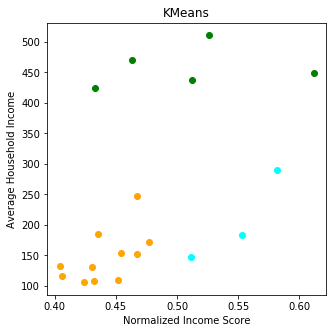

In [103]:
## Modified from exercise DP0701EN-3-3-1
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(5, 5))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
#colors = plt.cm.Spectral(np.linspace(0, 1, kclusters))

#Look at the specific data
plt_df = houston_clustered_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0)].reset_index(drop=True) # looking at total income info

# create a plot
ax = fig.add_subplot(1, 1, 1)

colors = ['red', 'blue', 'green', 'purple', 'cyan', 'orange']

# loop through the data and plot the datapoints
# k will match the number of clusters in the dataset.
for k, col in zip(range(kclusters), colors):
   
    if k in [2, 4, 5]:
    # plot the datapoints with color col.
    #ax.plot(plt_df[plt_df['cluster'] == k]['normalized income score'], plt_df[plt_df['cluster'] == k]['average household income'], colors[k],  marker='o')
        ax.plot(plt_df[plt_df['cluster'] == k]['normalized income score'], plt_df[plt_df['cluster'] == k]['average household income'], colors[k],  marker='o', linestyle = '')
    #plt.scatter(plt_df[plt_df['cluster'] == k]['normalized income score'], plt_df[plt_df['cluster'] == k]['average household income'], colors[k], marker = 'o')
    
# title of the plot
ax.set_title('KMeans')
ax.set_xlabel('Normalized Income Score')
ax.set_ylabel('Average Household Income')

# remove x-axis ticks
#ax.set_xticks(())

# remove y-axis ticks
#ax.set_yticks(())

# show the plot
plt.show()

In [3]:
# Zero map around west university
latitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'latitude'])
longitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'longitude'])

##choose the data to be displayed
#column = 'average household income'
#column = 'total high earners'
#column = 'normalized income score'
#column = 'income per section'
column = 'cluster'
year = '2012'
folium_df = houston_clustered_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0) & (houston_clustered_df['cluster'].isin(['2', '4', '5']))].reset_index(drop=True) # looking at total income info


m = folium .Map(
    location=[latitude, longitude],
    zoom_start=10)

m.choropleth(
#folium.Choropleth(  # doesn't work in cognitiveclassAI, but works in Anaconda
    geo_data = houston_JSON_file,
    data = folium_df,
    columns = ['zip code', column],
    key_on='feature.properties.zip code',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.8,
    legend_name = column + ' in year ' + year 
    )\
#    .add_to(m)

# add markers to indicate zip code and column data
for lat, lng, label, income in zip(folium_df['latitude'], folium_df['longitude'], folium_df['zip code'], folium_df[column]): 
    # round to two decimal points where needed
    if column in ['normalized income score', 'households per section']:
        round_digits = 2
    else:
        round_digits = None
    
    # show dollar signs for related columns
    if column in ['average household income']:
        popup_text = str(label) + '<br>$' + str(round(income, round_digits)) + 'k'
    elif column in ['income per section']:        
        popup_text = str(label) + '<br>$' + str(round(income/1000, round_digits)) + 'M'
    else:
        popup_text = str(label) + '<br>' + str(round(income, round_digits))
    folium.Circle(location=[lat,lng], radius = radius, color = 'blue', fill = True, fill_color = 'blue', popup = popup_text).add_to(m)
m
    
m

In [105]:
# Eliminate unused clusters and store for later use
houston_HI_df = houston_clustered_df[houston_clustered_df['cluster'].isin(['2', '4', '5'])].reset_index(drop = True)

# write to CSV file to allow later sessions to skip this cell
houston_HI_df.to_csv("houston_high_income.csv", index=False)

In [22]:
# define lookup for mapping clusters
houston_cluster_lookup = dict(zip(houston_HI_df['zip code'], houston_HI_df['cluster']))

# update venue count and save for later
houston_HI_venue_count_df = houston_venue_count_df[houston_venue_count_df['zip code'].isin(houston_HI_zips)].reset_index(drop = True)
houston_HI_venue_count_df = houston_HI_venue_count_df.loc[:, (houston_HI_venue_count_df != 0).any(axis = 0)]
houston_HI_venue_count_df.insert(loc = 1, column = 'cluster', value = houston_HI_venue_count_df['zip code'].map(houston_cluster_lookup))

# write to CSV file to allow later sessions to skip this cell
houston_HI_venue_count_df.to_csv('HI_venue_count.csv', index=False)

In [45]:
# Eliminate 77406
houston_HI_df = houston_HI_df[houston_HI_df['zip code'] != '77406'].reset_index(drop = True)
houston_HI_venue_count_df = houston_HI_venue_count_df[houston_HI_venue_count_df['zip code'] != '77406'].reset_index(drop = True)

# write to CSV file to allow later sessions to skip this cell
houston_HI_df.to_csv("houston_high_income.csv", index=False)
houston_HI_venue_count_df.to_csv('HI_venue_count.csv', index=False)

In [80]:
# Create a relative value of each restaurant type for each zip code but keep total count
houston_HI_venue_scaled_df = houston_HI_venue_count_df.copy()
houston_HI_venue_scaled_df.set_index(['zip code', 'cluster'], inplace = True)
temp_count = houston_HI_venue_scaled_df['restaurant count']
houston_HI_venue_scaled_df = houston_HI_venue_scaled_df.div(houston_HI_venue_scaled_df['restaurant count'], axis = 0)
houston_HI_venue_scaled_df['restaurant count'] = temp_count
houston_HI_venue_scaled_df.reset_index(inplace = True)

# write to CSV file to allow later sessions to skip this cell
houston_HI_venue_scaled_df.to_csv("HI_venue_count_scaled.csv", index=False)

In [8]:
houston_HI_venue_scaled_df.head()

zip code  cluster  Afghan Restaurant  African Restaurant  \
0    77002        2                0.0            0.000970   
1    77005        2                0.0            0.000000   
2    77006        5                0.0            0.000886   
3    77007        5                0.0            0.000000   
4    77008        5                0.0            0.000938   

   American Restaurant  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0.064985     0.0          0.000000                0.000485   
1             0.074203     0.0          0.000580                0.000000   
2             0.070891     0.0          0.000443                0.000443   
3             0.088186     0.0          0.001664                0.000000   
4             0.073171     0.0          0.000000                0.000000   

   Asian Restaurant  BBQ Joint  ...  Theme Restaurant  Tiki Bar  \
0          0.012124   0.022793  ...          0.002910  0.000000   
1          0.023768   0.011594  ...          0.000000  0.000000   
2          0.015064   0.015950  ...          0.000886  0.000000   
3          0.009983   0.004160  ...          0.000000  0.000000   
4          0.013133   0.022514  ...          0.000000  0.000938   

   Turkish Restaurant  Vegetarian / Vegan Restaurant  Venezuelan Restaurant  \
0            0.000970                       0.007274                    0.0   
1            0.002899                       0.010435                    0.0   
2            0.000000                       0.012406                    0.0   
3            0.000000                       0.011647                    0.0   
4            0.000000                       0.015009                    0.0   

   Vietnamese Restaurant  Whisky Bar  Wine Bar  Wings Joint  restaurant count  
0               0.040737    0.000000  0.003880     0.001455              2062  
1               0.010435    0.000000  0.003478     0.004058              1725  
2               0.033673    0.000443  0.004874     0.002215              2257  
3               0.017471    0.000000  0.000000     0.007488              1202  
4               0.024390    0.000000  0.000000     0.005629              1066  

[5 rows x 142 columns]

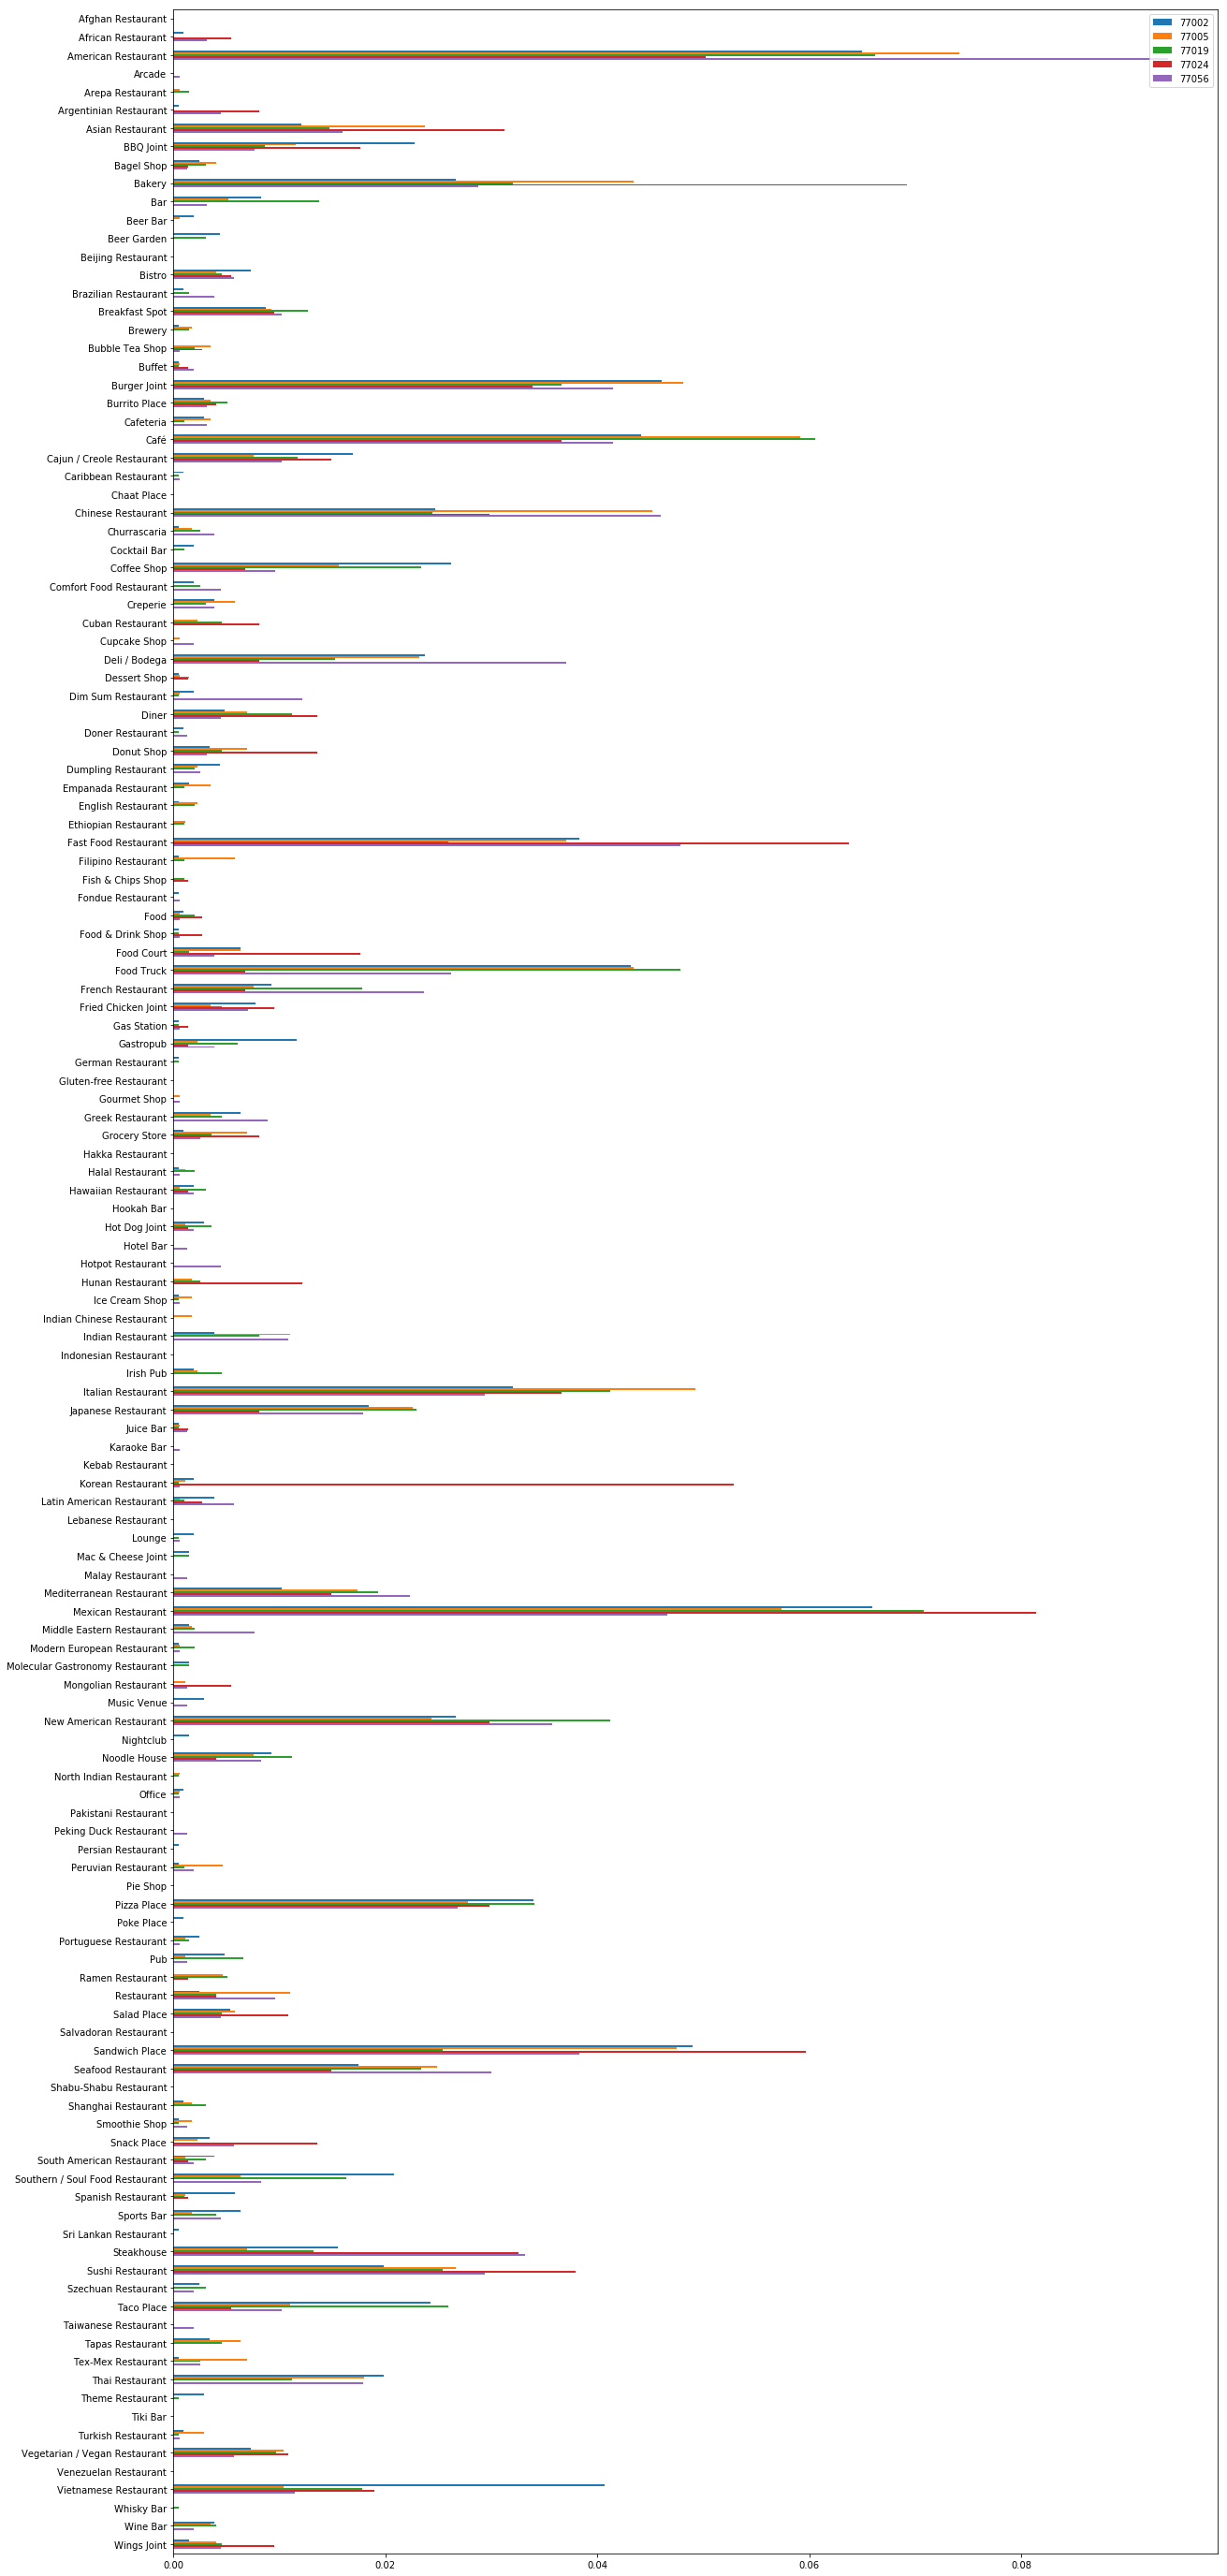

In [7]:
test = houston_HI_venue_scaled_df[houston_HI_venue_scaled_df['cluster'] == 2].reset_index(drop = True)
test.drop(columns = ['cluster', 'restaurant count'], axis = 0, inplace = True)
test.set_index('zip code', inplace = True)
ax = test.transpose().plot.barh(figsize = (20, 50))
plt.gca().invert_yaxis()
plt.legend(loc = 'upper right')
plt.show()

In [9]:
test = houston_HI_venue_scaled_df[houston_HI_venue_scaled_df['cluster'] == 2].reset_index(drop = True)
test.drop(columns = ['cluster', 'restaurant count'], axis = 0, inplace = True)
test.set_index('zip code', inplace = True)
cluster_dfs = {}
cluster_dfs[2] = test.transpose()

In [37]:
## create a dictionary of dataframes for restuarant frequencies within clusters
clusters = [2, 4, 5]
cluster_dfs = {}
threshold = 0.01  # minimum average frequency across cluster to be considered

for cluster in clusters:    
    # Narrow to cluster, drop cluster value and totals, then transpose so categories are the index
    temp_df = houston_HI_venue_scaled_df[houston_HI_venue_scaled_df['cluster'] == cluster].reset_index(drop = True)
    temp_df.drop(columns = ['cluster', 'restaurant count'], axis = 0, inplace = True)
    temp_df.set_index('zip code', inplace = True)
    temp_df = temp_df.transpose()
    
    # keep only categories where the mean frequency across the cluster exceeds the threshold
    temp_df = temp_df[temp_df.mean(axis = 1) > threshold]
    
    # save to cluster dictionary
    cluster_dfs[cluster] = temp_df
    
    # print confirmation with remaining category count
    print('Cluster ' + str(cluster) + ' has ' + str(temp_df.shape[0]) + ' restaurant categories with an average frequency exceeding ' + str(threshold))
    
# output common categories
common = set(cluster_dfs[2].index) & set(cluster_dfs[4].index) & set(cluster_dfs[5].index)
print()
print('There are ' + str(len(common)) + ' restaurant categories common to all selected clusters:')
print(*sorted(common), sep = '\n')

Cluster 2 has 29 restaurant categories with an average frequency exceeding 0.01
Cluster 4 has 31 restaurant categories with an average frequency exceeding 0.01
Cluster 5 has 31 restaurant categories with an average frequency exceeding 0.01

There are 22 restaurant categories common to all selected clusters:
American Restaurant
Asian Restaurant
Bakery
Breakfast Spot
Burger Joint
Café
Cajun / Creole Restaurant
Chinese Restaurant
Coffee Shop
Deli / Bodega
Fast Food Restaurant
Italian Restaurant
Japanese Restaurant
Mediterranean Restaurant
Mexican Restaurant
Pizza Place
Sandwich Place
Seafood Restaurant
Sushi Restaurant
Taco Place
Thai Restaurant
Vietnamese Restaurant


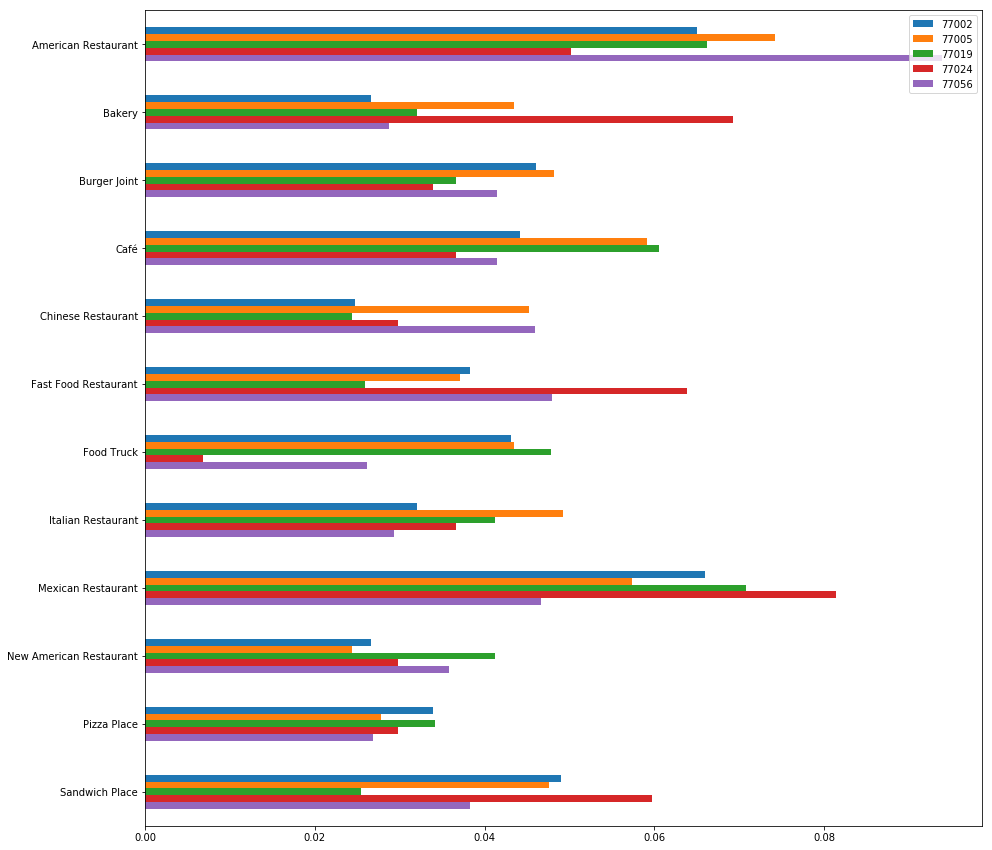

In [24]:
ax = cluster_dfs[2].plot.barh(figsize = (15, 15))
plt.gca().invert_yaxis()
plt.legend(loc = 'upper right')
plt.show()

In [59]:
clusters = [2, 4, 5]
cluster_outliers = {}

for cluster in clusters:
    # compare frequency value to 1/3 of the mean value, showing returning all rows where a value in the row is True
    outliers = (cluster_dfs[cluster].subtract(cluster_dfs[cluster].mean(axis = 1) * 0.33, axis = 0) < 0).any(axis = 1)
    
    # store new DataFrames with filtered data
    cluster_outliers[cluster] = cluster_dfs[cluster][outliers]    
    
    #report results
    print (str(cluster_outliers[cluster].shape[0]) + ' outlier categories found for cluster ' + str(cluster))

4 outlier categories found for cluster 2
13 outlier categories found for cluster 4
13 outlier categories found for cluster 5


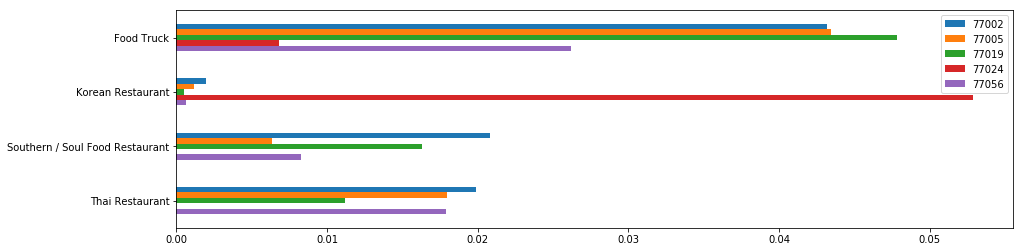

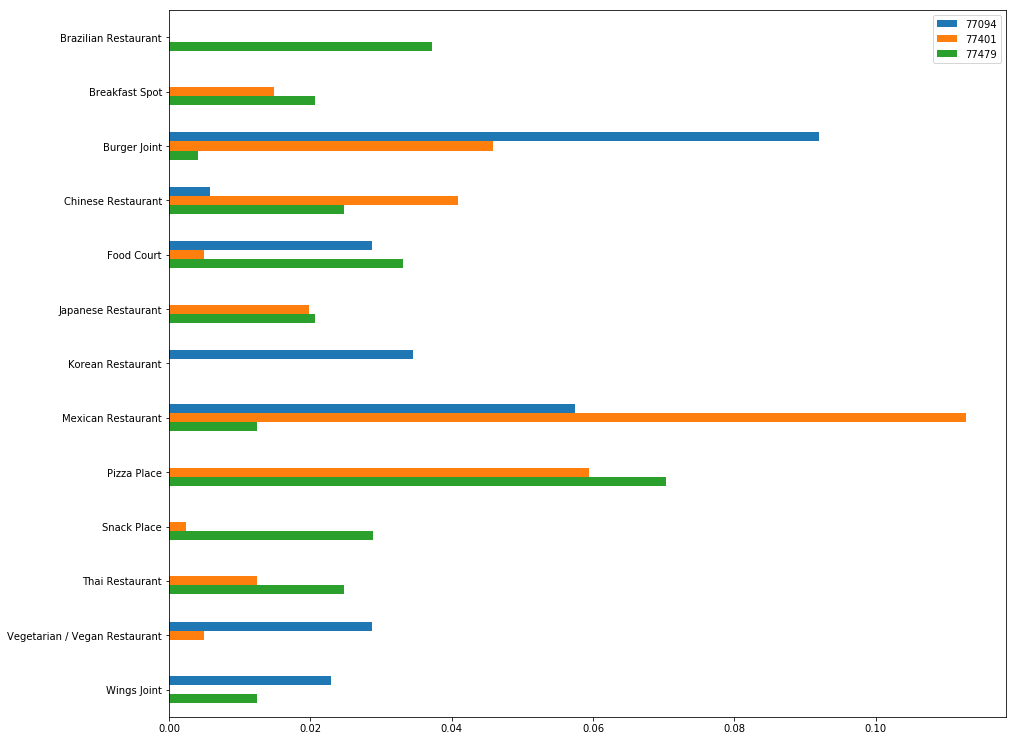

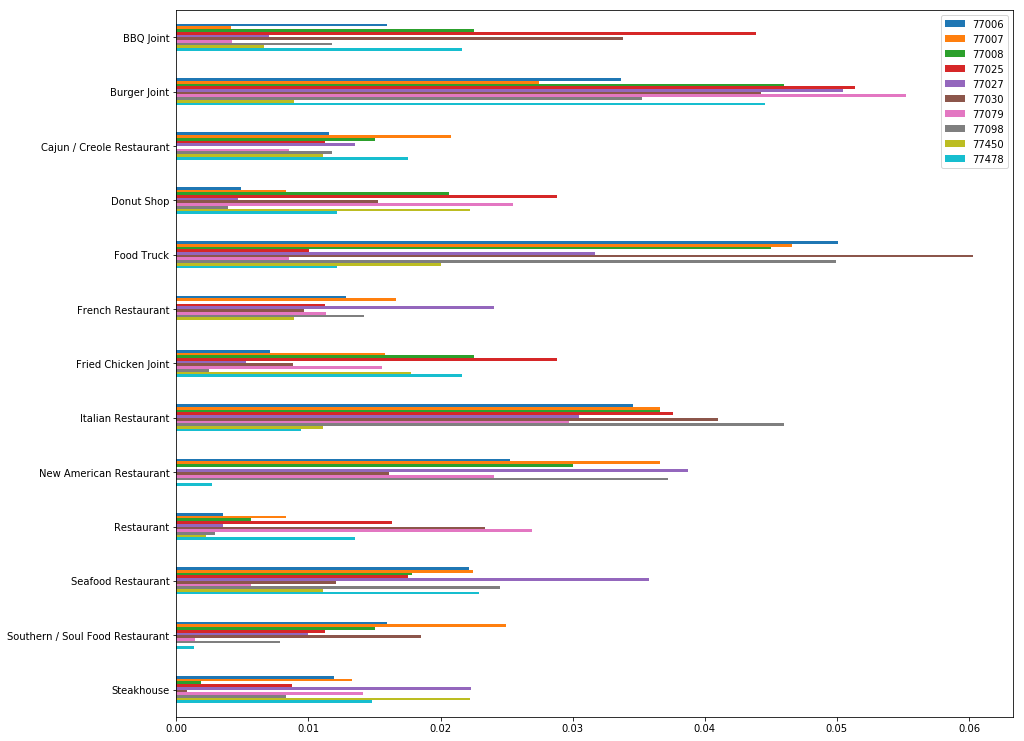

In [60]:
# plot clusters with only outliers
for cluster in clusters:
    ax = cluster_outliers[cluster].plot.barh(figsize = (15, cluster_outliers[cluster].shape[0]))
    plt.gca().invert_yaxis()
    plt.legend(loc = 'upper right')
    plt.show()

In [62]:
# output common categories
common = set(cluster_outliers[2].index) & set(cluster_outliers[4].index) & set(cluster_outliers[5].index)
print()
print('There are ' + str(len(common)) + ' restaurant categories common to all selected clusters:')
print(*sorted(common), sep = '\n')


There are 0 restaurant categories common to all selected clusters:



In [63]:
cluster_outliers[2].index

Index(['Food Truck', 'Korean Restaurant', 'Southern / Soul Food Restaurant',
       'Thai Restaurant'],
      dtype='object')

In [64]:
cluster_outliers[4].index

Index(['Brazilian Restaurant', 'Breakfast Spot', 'Burger Joint',
       'Chinese Restaurant', 'Food Court', 'Japanese Restaurant',
       'Korean Restaurant', 'Mexican Restaurant', 'Pizza Place', 'Snack Place',
       'Thai Restaurant', 'Vegetarian / Vegan Restaurant', 'Wings Joint'],
      dtype='object')

In [65]:
cluster_outliers[5].index

Index(['BBQ Joint', 'Burger Joint', 'Cajun / Creole Restaurant', 'Donut Shop',
       'Food Truck', 'French Restaurant', 'Fried Chicken Joint',
       'Italian Restaurant', 'New American Restaurant', 'Restaurant',
       'Seafood Restaurant', 'Southern / Soul Food Restaurant', 'Steakhouse'],
      dtype='object')

In [13]:
report_columns = ['zip code',
                 'returns',
                 'total AGI',
                 'normalized income score',
                 'total high earners',
                 'percent high earners',
                 'average household income',
                 'restaurant count',
                 'restaurants per household',
                 'cluster']
houston_HI_df[(houston_HI_df['year'] == '2012') & (houston_HI_df['income bracket'] == 0)][report_columns]

zip code  returns  total AGI  normalized income score  total high earners  \
0      77002   4880.0  2067824.0                 0.433197              1570.0   
35     77005  11090.0  4983523.0                 0.611542              6140.0   
70     77006  12050.0  1596949.0                 0.404315              3340.0   
105    77007  19360.0  3333203.0                 0.476756              6990.0   
140    77008  17300.0  1858315.0                 0.431792              5500.0   
175    77019  11840.0  5572872.0                 0.463007              4190.0   
210    77024  17570.0  8973976.0                 0.526010              7830.0   
245    77025  12120.0  1401085.0                 0.405776              3590.0   
280    77027   9710.0  2401290.0                 0.467559              3260.0   
315    77030   5100.0   774234.0                 0.467451              1780.0   
350    77056  11100.0  4857996.0                 0.512613              4550.0   
385    77079  15570.0  2384056.0                 0.454207              5760.0   
420    77094   4590.0   843334.0                 0.552941              2290.0   
455    77098   8110.0  1497937.0                 0.435758              2550.0   
490    77401   7990.0  2316414.0                 0.581477              4190.0   
525    77450  30590.0  3231062.0                 0.423799              9980.0   
560    77478  12440.0  1621592.0                 0.430386              4050.0   
595    77479  33720.0  4987378.0                 0.511447             14970.0   

     percent high earners  average household income  restaurant count  \
0                0.321721                423.734426              2062   
35               0.553652                449.370875              1725   
70               0.277178                132.526888              2257   
105              0.361054                172.169576              1202   
140              0.317919                107.417052              1066   
175              0.353885                470.681757              1964   
210              0.445646                510.755606               737   
245              0.296205                115.601073               798   
280              0.335736                247.300721              1704   
315              0.349020                151.810588              1243   
350              0.409910                437.657297              1566   
385              0.369942                153.118561               706   
420              0.498911                183.732898               174   
455              0.314427                184.702466              2043   
490              0.524406                289.914143               807   
525              0.326250                105.624779               450   
560              0.325563                130.353055               741   
595              0.443950                147.905635               242   

     restaurants per household  cluster  
0                     0.422541        2  
35                    0.155546        2  
70                    0.187303        5  
105                   0.062087        5  
140                   0.061618        5  
175                   0.165878        2  
210                   0.041946        2  
245                   0.065842        5  
280                   0.175489        5  
315                   0.243725        5  
350                   0.141081        2  
385                   0.045344        5  
420                   0.037908        4  
455                   0.251911        5  
490                   0.101001        4  
525                   0.014711        5  
560                   0.059566        5  
595                   0.007177        4

In [68]:
# Zero map around west university
latitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'latitude'])
longitude = float(houston_zips_df.loc[houston_zips_df['zip code'] == '77005', 'longitude'])

##choose the data to be displayed
column = 'average household income'
#column = 'total high earners'
#column = 'normalized income score'
#column = 'income per section'
#column = 'cluster'
year = '2012'
folium_df = houston_clustered_df[(houston_df['year']==year) & (houston_df['income bracket'] == 0) & (houston_clustered_df['cluster'].isin(['5']))].reset_index(drop=True) # looking at total income info


m = folium .Map(
    location=[latitude, longitude],
    zoom_start=10)

m.choropleth(
#folium.Choropleth(  # doesn't work in cognitiveclassAI, but works in Anaconda
    geo_data = houston_JSON_file,
    data = folium_df,
    columns = ['zip code', column],
    key_on='feature.properties.zip code',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=0.8,
    legend_name = column + ' in year ' + year 
    )\
#    .add_to(m)

# add markers to indicate zip code and column data
for lat, lng, label, income in zip(folium_df['latitude'], folium_df['longitude'], folium_df['zip code'], folium_df[column]): 
    # round to two decimal points where needed
    if column in ['normalized income score', 'households per section']:
        round_digits = 2
    else:
        round_digits = None
    
    # show dollar signs for related columns
    if column in ['average household income']:
        popup_text = str(label) + '<br>$' + str(round(income, round_digits)) + 'k'
    elif column in ['income per section']:        
        popup_text = str(label) + '<br>$' + str(round(income/1000, round_digits)) + 'M'
    else:
        popup_text = str(label) + '<br>' + str(round(income, round_digits))
    folium.Circle(location=[lat,lng], radius = radius, color = 'blue', fill = True, fill_color = 'blue', popup = popup_text).add_to(m)
m
    
m

In [ ]:
## Correlate income profiles to restaurant preferences
1. Look at income trends within the selected zip codes
    2.  

## Setup Report Formats
1. Define columns for printout

In [6]:
report_columns = ['zip code', 'year', 'returns', 'total AGI', 'income bracket',
                  'average household income', 'households per section', 'income per section', 'normalized income score',
                  'total high earners', 'percent high earners', 'high earners per section']


In [7]:
#houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2012')][report_columns].sort_values(by = 'total high earners', ascending = False).head(10)
#houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2012')][report_columns].sort_values(by = 'high earners per section', ascending = False).head(10)
#houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2012')][report_columns].sort_values(by = 'income per section', ascending = False).head(10)
houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2012')][report_columns].sort_values(by = 'average household income', ascending = False).head(10)
#houston_df[(houston_df['income bracket'] == 0) & (houston_df['year'] == '2016')][report_columns].sort_values(by = 'returns', ascending = True).head(10)

zip code  year  returns  total AGI  income bracket  \
700     77024  2012  17570.0  8973976.0               0   
525     77019  2012  11840.0  5572872.0               0   
105     77005  2012  11090.0  4983523.0               0   
1680    77056  2012  11100.0  4857996.0               0   
0       77002  2012   4880.0  2067824.0               0   
2695    77401  2012   7990.0  2316414.0               0   
805     77027  2012   9710.0  2401290.0               0   
2625    77098  2012   8110.0  1497937.0               0   
2555    77094  2012   4590.0   843334.0               0   
175     77007  2012  19360.0  3333203.0               0   

      average household income  households per section  income per section  \
700                 510.755606             1378.547316        7.041008e+05   
525                 470.681757             3325.795313        1.565391e+06   
105                 449.370875             2884.068417        1.296016e+06   
1680                437.657297             3196.066195        1.398782e+06   
0                   423.734426             2359.833271        9.999426e+05   
2695                289.914143             2129.471389        6.173639e+05   
805                 247.300721             3374.922863        8.346209e+05   
2625                184.702466             4567.985547        8.437182e+05   
2555                183.732898              396.178445        7.279101e+04   
175                 172.169576             2451.196205        4.220214e+05   

      normalized income score  total high earners  percent high earners  \
700                  0.526010              7830.0              0.445646   
525                  0.463007              4190.0              0.353885   
105                  0.611542              6140.0              0.553652   
1680                 0.512613              4550.0              0.409910   
0                    0.433197              1570.0              0.321721   
2695                 0.581477              4190.0              0.524406   
805                  0.467559              3260.0              0.335736   
2625                 0.435758              2550.0              0.314427   
2555                 0.552941              2290.0              0.498911   
175                  0.476756              6990.0              0.361054   

      high earners per section  
700                 614.344080  
525                1176.949524  
105                1596.770070  
1680               1310.099206  
0                   759.208655  
2695               1116.706523  
805                1133.084298  
2625               1436.296319  
2555                197.657656  
175                 885.013506

# From DV101EN-3-5-1
world_geo = r'world_countries.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_can['Total'].min(),
                              df_can['Total'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=df_can,
    columns=['Country', 'Total'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Immigration to Canada',
    reset=True
)
world_map

In [383]:
with open('tx_zip_codes.json') as json_data:
    tx_data = json.load(json_data)

In [ ]:
# Import zip code data using GeoPandas
zips_df = gpd.read_file('tx_zip_codes.json')
print('shape', zips_df.shape,'before dropping zip codes')

# filter to Houston zip codes
zips_df = zips_df[zips_df['ZCTA5CE10'].astype('int32') % 77000 < 1000].reset_index(drop = True)
zips_df = zips_df[zips_df['ZCTA5CE10'].astype('int32') != 0].reset_index(drop = True)
print('shape', zips_df.shape, 'after dropping zip codes')

In [388]:
zips_df.head()

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  \
0        48      77578  4877578        B5   G6350          S   96568416   
1        48      77430  4877430        B5   G6350          S  289124677   
2        48      77808  4877808        B5   G6350          S  647488798   
3        48      77982  4877982        B5   G6350          S   33189469   
4        48      77665  4877665        B5   G6350          S  348794493   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0    166211  +29.4814606  -095.3614017         N   
1  21492012  +29.2598778  -095.6676621         N   
2   4554975  +30.7977360  -096.3120843         N   
3   7109281  +28.4446441  -096.4917884         N   
4   2833218  +29.8129989  -094.4161167         N   

                                            geometry  
0  POLYGON ((-95.383662 29.533515, -95.383667 29....  
1  POLYGON ((-95.59308799999999 29.377608, -95.59...  
2  POLYGON ((-96.319086 30.670924, -96.319092 30....  
3  POLYGON ((-96.458792 28.431083, -96.464726 28....  
4  POLYGON ((-94.47511799999999 29.762129, -94.47...

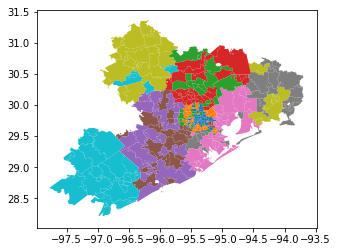

In [20]:
zips_df.plot(column = 'ZCTA5CE10');

In [66]:
irs_data.head(10)
irs_data[['zip code', 'total taxable income']]
richest = irs_data[irs_data['income bracket'] == 6].reset_index(drop = True)
richest.head()

zip code  income bracket  returns  total AGI  number unemployment  \
0     77002               6    710.0  1619721.0                  0.0   
1     77003               6    120.0    36435.0                  0.0   
2     77004               6    710.0   398243.0                  0.0   
3     77005               6   4440.0  4559743.0                 40.0   
4     77006               6   1410.0   979144.0                 20.0   

   total unemployement  number social security  total social security  \
0                  0.0                    80.0                 1991.0   
1                  0.0                     0.0                    0.0   
2                  0.0                   100.0                 2643.0   
3                216.0                   560.0                14555.0   
4                193.0                   170.0                 4129.0   

   number mortgage interest  total mortgage interest  ...  \
0                     320.0                   6010.0  ...   
1                      90.0                    951.0  ...   
2                     430.0                   5963.0  ...   
3                    3130.0                  63384.0  ...   
4                     940.0                  13475.0  ...   

   total child care credit  number child tax credit  total child tax credit  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                     27.0                      0.0                     0.0   
3                    276.0                      0.0                     0.0   
4                     44.0                      0.0                     0.0   

   number income tax  total income tax  number taxes due  total taxes due  \
0              710.0          346219.0             290.0          12283.0   
1              120.0            7852.0              60.0           1101.0   
2              710.0           91922.0             350.0           6854.0   
3             4430.0         1133478.0            1910.0          63967.0   
4             1410.0          226530.0             660.0          18316.0   

   number refunds due  total refunds due  year  
0               220.0             9668.0  2012  
1                50.0              342.0  2012  
2               270.0             3659.0  2012  
3              1440.0            32413.0  2012  
4               510.0             6232.0  2012  

[5 rows x 25 columns]

In [63]:
test = richest
#test.rename(columns = {'zip code': 'ZCTA5CE10'}, inplace = True)
test.head()
# test2 = zips_df.join(other = test, on = 'ZCTA5CE10')
# test2.head()
#year_df = pd.concat([year_df, year_totals_df], sort = False)
zips_test = zips_df
#zips_test['ZCTA5CE10'] = zips_test['ZCTA5CE10'].astype('int64')
test2 = zips_test.merge(test, left_on = 'ZCTA5CE10', right_on = 'ZCTA5CE10', suffixes = ('_left', '_right'))
test2.shape

(1602, 36)

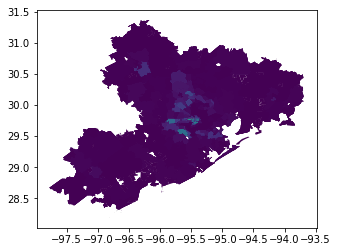

In [70]:
test2.plot(column = 'total taxable income')